<a href="https://colab.research.google.com/github/Sirmj-1986/Ca_Ka_Iron/blob/main/CKI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio
!pip install earthpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.4 MB/s eta 0:00:00


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import rasterio
import earthpy.plot as ep
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors
import seaborn as sns
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
Sample_Path = '/content/drive/MyDrive/GEE_Exports/Training_Samples_Fixed.csv'
Image_Path = '/content/drive/MyDrive/GEE_Exports/ImageG_Stacked_Float.tif'


In [5]:
Bands = ['PC2', 'PC3', 'PC5', 'geology','B09', 'B08', 'B07', 'B05', 'B06', 'B3N',
  'Calcite_SAM', 'Kaolinite_SAM', 'IronOxide_SAM']  # Feature columns
LC = ['class']
Classes = [0, 1, 2, 3]
N_Classes = 4
Names = ["No_Alteration", "Calcite", "Kaolinite", "IronOxide"]
Palette = [
    '#008000',  # Green  for class 0 (No_Alteration)
    '#FF0000',  # Red    for class 1 (Calcite)
    '#0000FF',  # Blue   for class 2 (Kaolinite)
    '#FFD700',  # Gold   for class 3 (IronOxide)
]

Image has 13 bands.
Image dimensions: 321 rows x 757 columns
Coordinate Reference System (CRS): EPSG:4326


<Figure size 800x800 with 0 Axes>

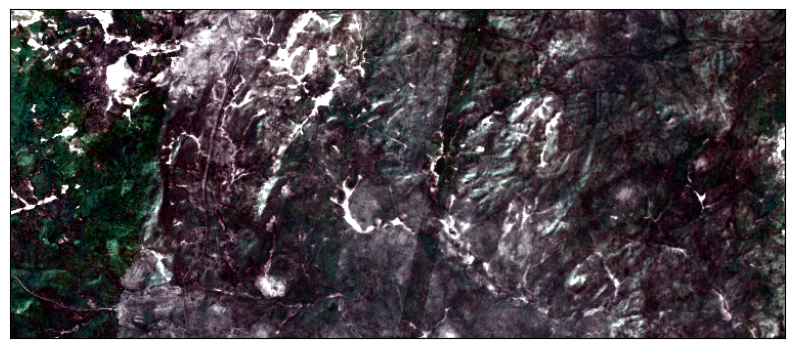

In [6]:
image = rasterio.open(Image_Path)

band_count = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform

print(f"Image has {band_count} bands.")
print(f"Image dimensions: {height} rows x {width} columns")
print(f"Coordinate Reference System (CRS): {crs}")

band_indices_for_vis = [Bands.index('Calcite_SAM') + 1, Bands.index('Kaolinite_SAM') + 1, Bands.index('IronOxide_SAM') + 1]

image_vis = []
for b_index in band_indices_for_vis:
    image_vis.append(image.read(b_index))
image_vis = np.stack(image_vis)

plt.figure(figsize=(8,8))
ep.plot_rgb(
    image_vis,
    stretch=True
)
plt.show()

In [7]:
df = pd.read_csv(Sample_Path)
print(df.head())

X = df[Bands]
y = df['class']

print(f"Missing values in features: {X.isnull().sum().sum()}")
print(f"Missing values in label: {y.isnull().sum()}")

# Split into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


  system:index   B05   B06        B07        B08        B09  B3N  Calcite_SAM  \
0    1_1_1_0_0   7.0   9.5  10.220835  10.229438   8.223329  4.5    18.902552   
1    1_1_1_1_0   3.0   2.0   0.220835   2.229438   0.723329  8.0    48.737519   
2    1_1_1_2_0  15.0  18.5  18.220835  18.729438  13.723329  4.0    14.232379   
3    1_1_1_3_0   2.0   3.0   3.220835   3.229438   2.223329  4.0    29.433654   
4    1_1_1_4_0  13.0  15.5  15.220835  16.229438  11.723329  5.0    16.650979   

   IronOxide_SAM  Kaolinite_SAM        PC2       PC3       PC5  class  \
0      20.040889      24.755917  10.306033 -3.073469  3.667933      0   
1      41.608680      41.136767  -2.688805 -6.491644  0.926022      0   
2      15.668853      19.731499  13.640194  0.081425  3.723284      0   
3      23.477301      28.250108   1.957668 -2.268212  2.162830      0   
4      18.921287      23.501282  15.892964 -3.004698  4.345870      0   

   geology                                               .geo  
0      363

/tmp/ipython-input-141434891.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


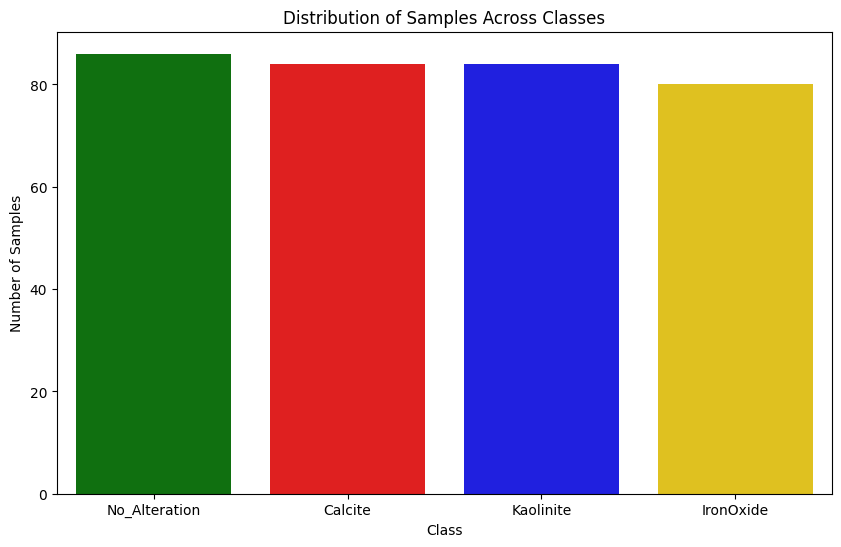

In [8]:
df_train = X_train.copy()
df_train['class'] = y_train.values

plt.figure(figsize=(10, 6))
sns.countplot(
    x='class',
    data=df_train,
    palette=Palette
)
plt.title('Distribution of Samples Across Classes')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(
    ticks=[0, 1, 2, 3],                           # Positions for each class
    labels=["No_Alteration", "Calcite", "Kaolinite", "IronOxide"]
)
plt.show()

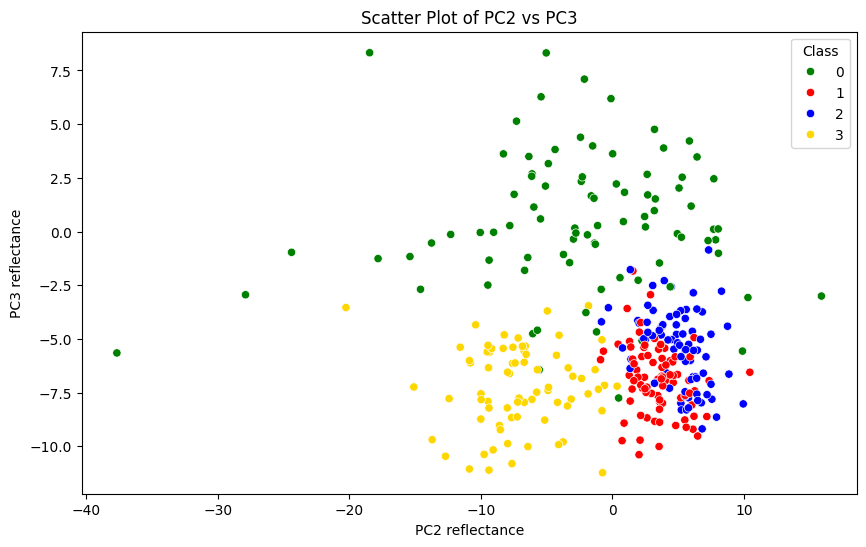

In [9]:
# Combine X_train with y_train for easy plotting
df_train = X_train.copy()
df_train['class'] = y_train.values

# Scatter plot of B4 vs B8, colored by 'class'
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PC2',
    y='PC3',
    hue='class',
    data=df_train,
    palette=Palette
)
plt.title('Scatter Plot of PC2 vs PC3')
plt.xlabel('PC2 reflectance')
plt.ylabel('PC3 reflectance')
plt.legend(title='Class')
plt.show()


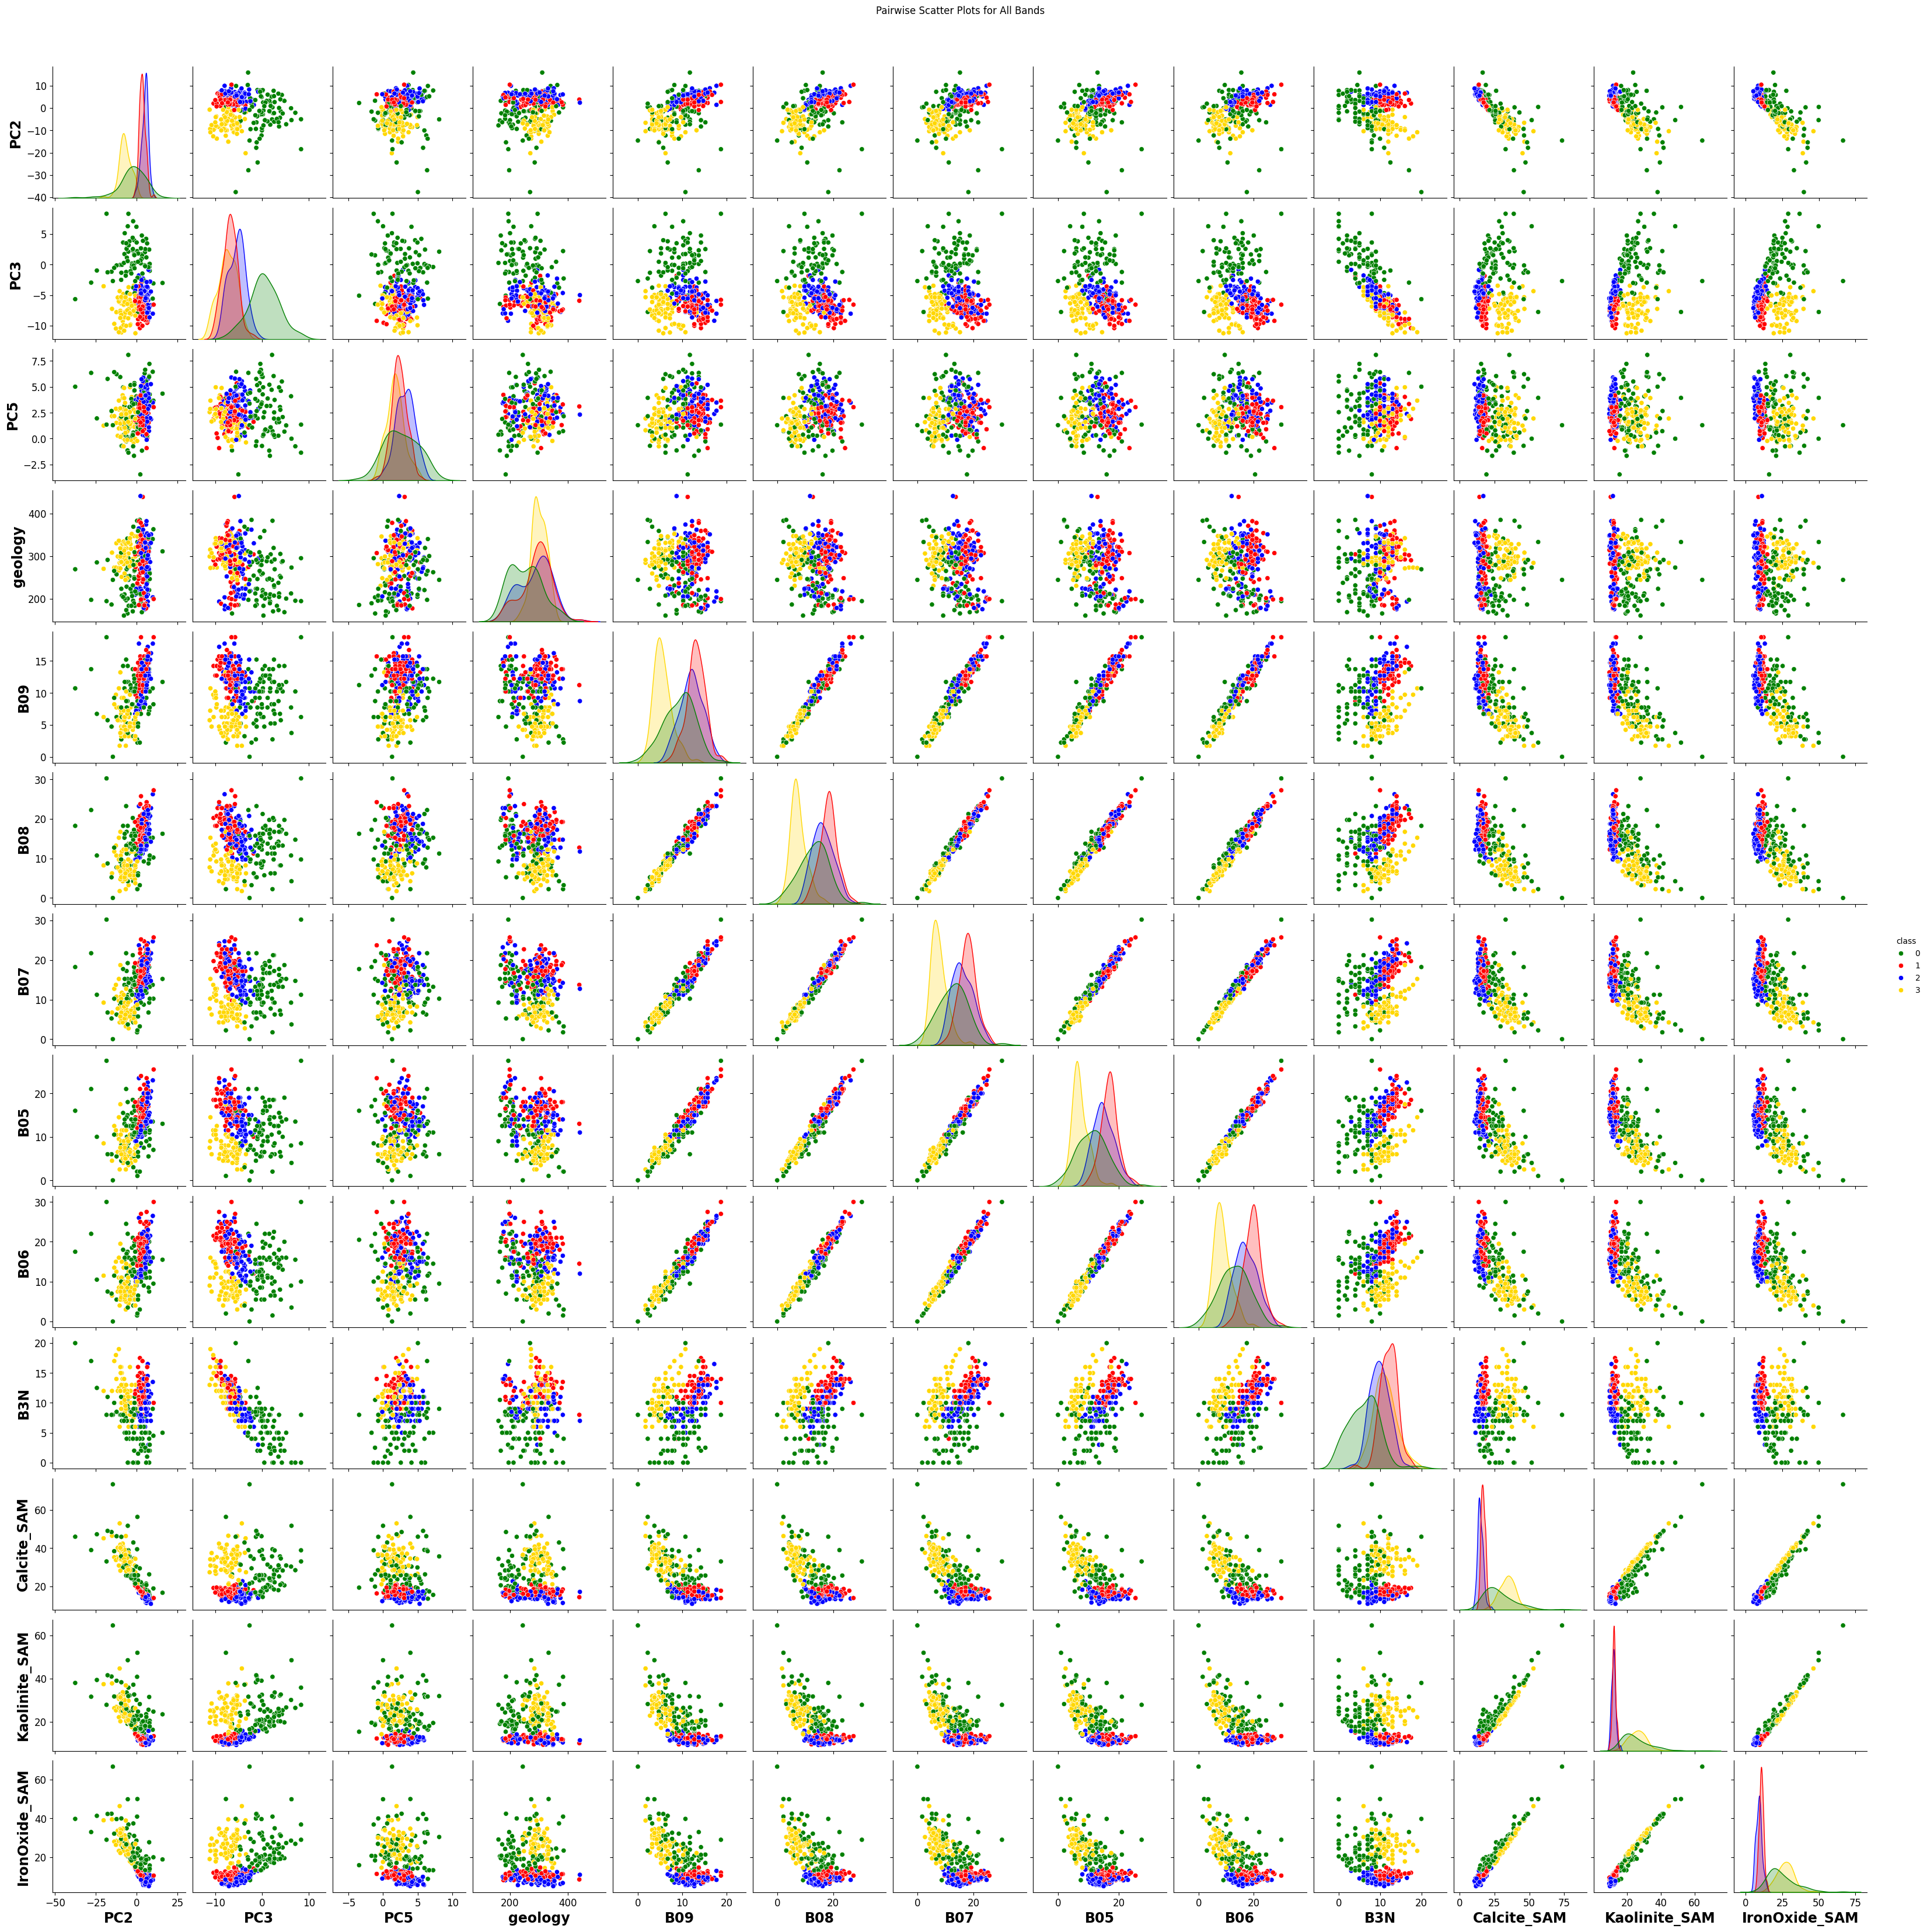

In [10]:
g = sns.pairplot(df_train, vars=Bands, hue='class', palette=Palette)
g.fig.suptitle('Pairwise Scatter Plots for All Bands', y=1.02)

for ax in g.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=17, fontweight='bold')
    ax.set_ylabel(ax.get_ylabel(), fontsize=17, fontweight='bold')
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

plt.show()

In [11]:
export_folder = '/content/drive/MyDrive/AGU'
export_filename = 'Pairwise_Scatter_Plot222.png'
export_path = os.path.join(export_folder, export_filename)

if not os.path.exists(export_folder):
    os.makedirs(export_folder)
g.savefig(export_path, dpi=1000, bbox_inches='tight')

print(f"Pair plot exported successfully to: {export_path}")

Pair plot exported successfully to: /content/drive/MyDrive/AGU/Pairwise_Scatter_Plot222.png


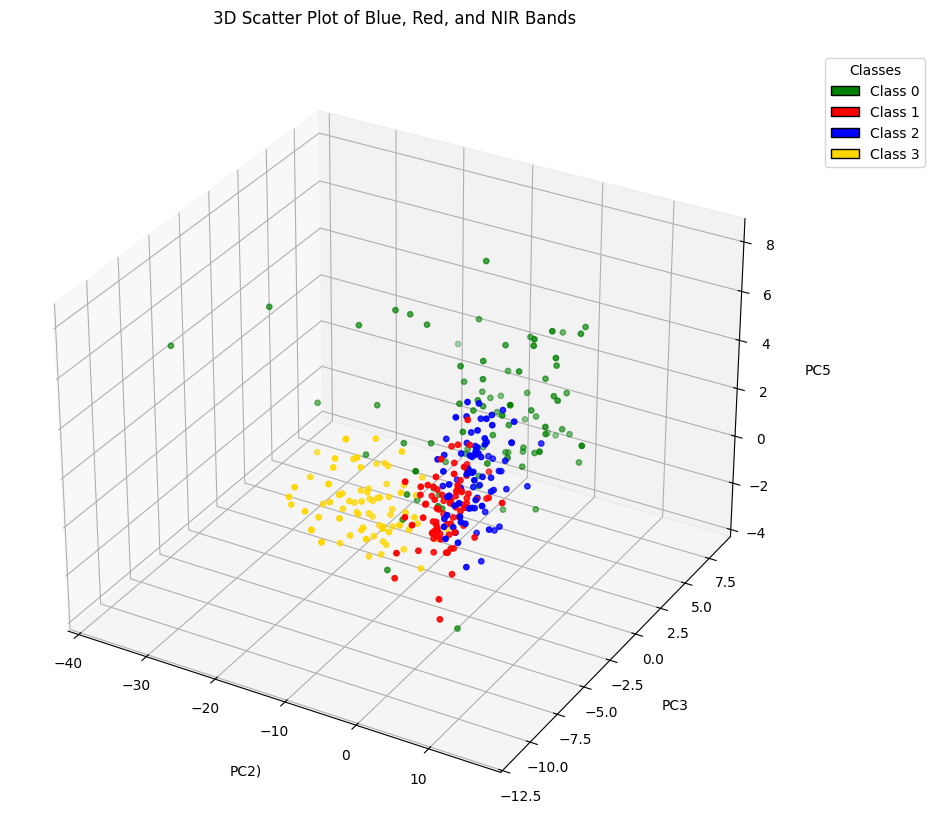

In [12]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch
color_map = {class_label: Palette[i] for i, class_label in enumerate(Classes)}
colors = df_train['class'].map(color_map)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    df_train['PC2'],
    df_train['PC3'],
    df_train['PC5'],
    c=colors,
    s=15
)
ax.set_xlabel('PC2)', labelpad=15)
ax.set_ylabel('PC3', labelpad=15)
ax.set_zlabel('PC5', labelpad=15)
ax.dist = 11

legend_elements = [
    Patch(facecolor=Palette[i], edgecolor='k', label=f'Class {Classes[i]}')
    for i in range(len(Classes))
]
ax.legend(
    handles=legend_elements,
    title="Classes",
    loc='upper left',
    bbox_to_anchor=(1.05, 1)
)
plt.title('3D Scatter Plot of Blue, Red, and NIR Bands', pad=20)

plt.show()



/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


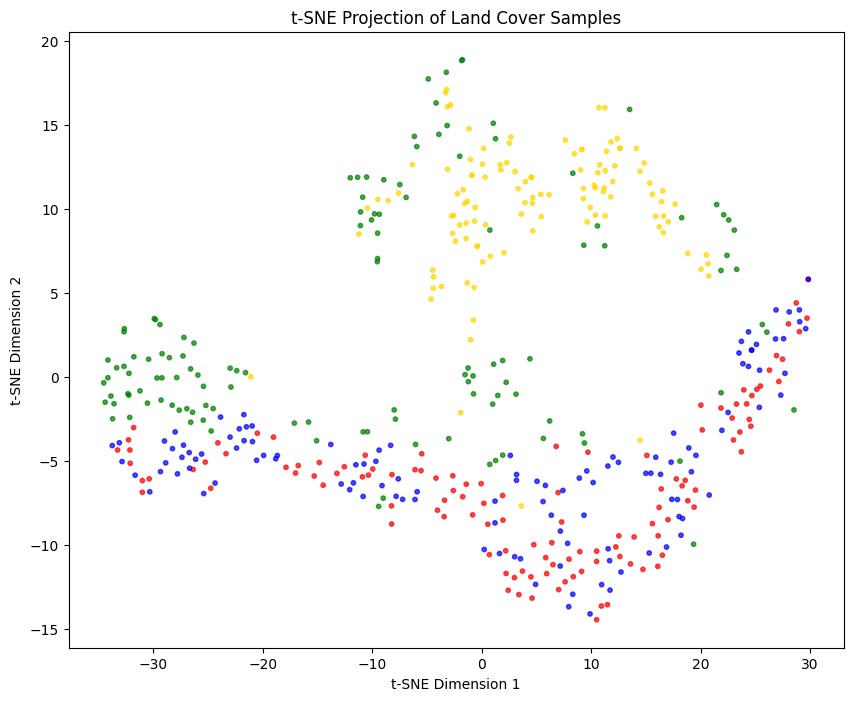

In [13]:
# Import TSNE
from sklearn.manifold import TSNE
tsne = TSNE(
    n_components=2,
    perplexity=30,
    random_state=42,
    n_iter=1000
)
X_tsne = tsne.fit_transform(X)
plt.figure(figsize=(10, 8))
colors = [color_map[label] for label in y]

plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=colors,
    s=10,
    alpha=0.7
)

plt.title("t-SNE Projection of Land Cover Samples")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

plt.show()

In [14]:
# Define hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Define hyperparameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Define hyperparameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

print("Hyperparameter grids defined.")

Hyperparameter grids defined.


In [15]:
# Random Forest Grid Search
rf_grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5
)
rf_grid_search.fit(X_train, y_train)

# SVM Grid Search
svm_grid_search = GridSearchCV(
    SVC(random_state=42, probability=True), # Add probability=True
    param_grid_svm,
    cv=5
)
svm_grid_search.fit(X_train, y_train)

# XGBoost Grid Search
from xgboost import XGBClassifier # Import XGBClassifier

xgb_grid_search = GridSearchCV(
    XGBClassifier(
        objective='multi:softmax',
        num_class=N_Classes,
        eval_metric='mlogloss',
        random_state=42
    ),
    param_grid_xgb,
    cv=5
)
xgb_grid_search.fit(X_train, y_train)

print("Grid search for all models complete.")

Grid search for all models complete.



** Random Forest **
Accuracy: 0.8194444444444444
              precision    recall  f1-score   support

           0       0.94      0.87      0.90        38
           1       0.74      0.78      0.76        36
           2       0.72      0.72      0.72        36
           3       0.89      0.91      0.90        34

    accuracy                           0.82       144
   macro avg       0.82      0.82      0.82       144
weighted avg       0.82      0.82      0.82       144



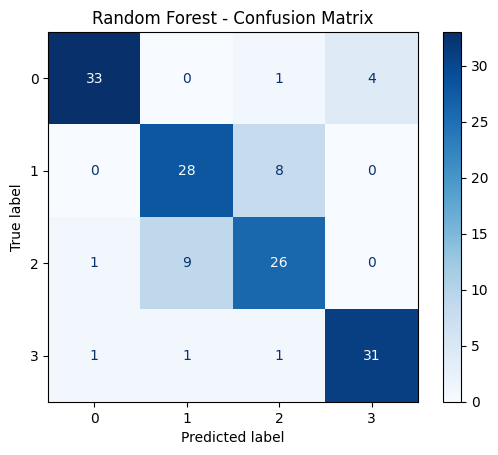


** SVM **
Accuracy: 0.7777777777777778
              precision    recall  f1-score   support

           0       0.89      0.82      0.85        38
           1       0.66      0.69      0.68        36
           2       0.71      0.67      0.69        36
           3       0.86      0.94      0.90        34

    accuracy                           0.78       144
   macro avg       0.78      0.78      0.78       144
weighted avg       0.78      0.78      0.78       144



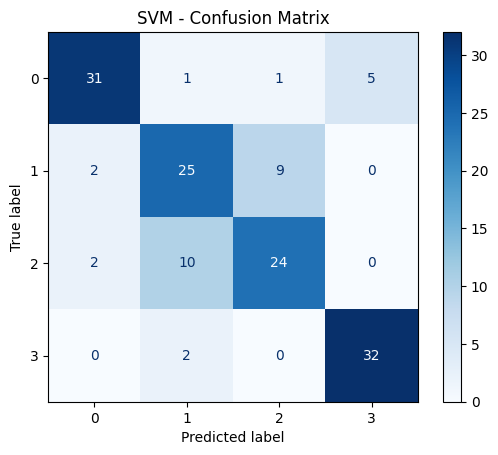


** XGBoost **
Accuracy: 0.7986111111111112
              precision    recall  f1-score   support

           0       0.91      0.76      0.83        38
           1       0.73      0.75      0.74        36
           2       0.77      0.75      0.76        36
           3       0.80      0.94      0.86        34

    accuracy                           0.80       144
   macro avg       0.80      0.80      0.80       144
weighted avg       0.80      0.80      0.80       144



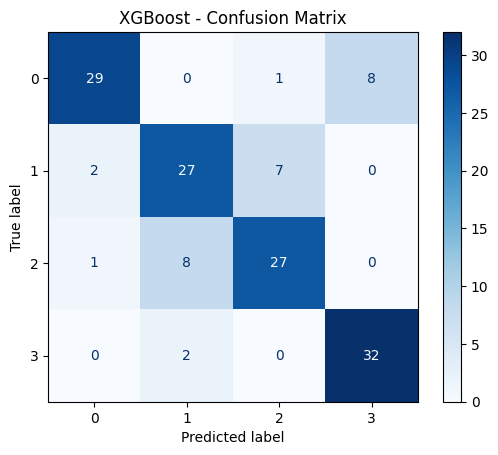

In [16]:
# Get the best models from grid search
best_rf = rf_grid_search.best_estimator_
best_svm = svm_grid_search.best_estimator_
best_xgb = xgb_grid_search.best_estimator_

# Make predictions on the test set using the best models
rf_preds = best_rf.predict(X_test)
svm_preds = best_svm.predict(X_test)
xgb_preds = best_xgb.predict(X_test)

# Evaluate each model
models = {
    "Random Forest": rf_preds,
    "SVM": svm_preds,
    "XGBoost": xgb_preds
}

for name, preds in models.items():
    print(f"\n** {name} **")
    print("Accuracy:", (preds == y_test).mean())

    # Classification Report
    print(classification_report(y_test, preds))

    # Confusion Matrix
    cm = confusion_matrix(y_test, preds, labels=Classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Classes)
    disp.plot(cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

In [17]:
img_array = image.read()
print("Image array shape:", img_array.shape)

Image array shape: (13, 321, 757)


In [18]:
img_reshaped = img_array.reshape(band_count, -1).T
print("Reshaped array for prediction:", img_reshaped.shape)


Reshaped array for prediction: (242997, 13)


In [19]:
rf_prediction = best_rf.predict(img_reshaped)
svm_prediction = best_svm.predict(img_reshaped)
xgb_prediction = best_xgb.predict(img_reshaped)

print("Predictions made for all models on the image data.")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Predictions made for all models on the image data.



** Tuned Random Forest **
Accuracy: 0.8194444444444444
               precision    recall  f1-score   support

No_Alteration       0.94      0.87      0.90        38
      Calcite       0.74      0.78      0.76        36
    Kaolinite       0.72      0.72      0.72        36
    IronOxide       0.89      0.91      0.90        34

     accuracy                           0.82       144
    macro avg       0.82      0.82      0.82       144
 weighted avg       0.82      0.82      0.82       144



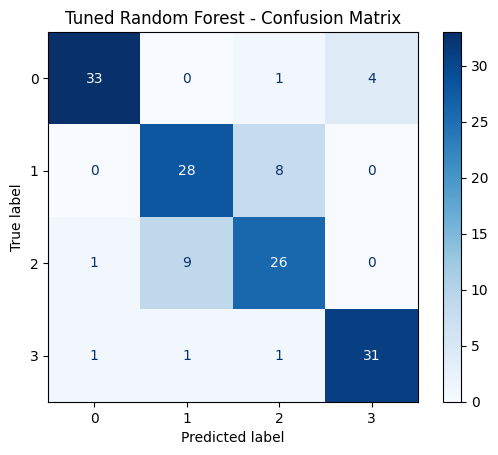


** Tuned SVM **
Accuracy: 0.7777777777777778
               precision    recall  f1-score   support

No_Alteration       0.89      0.82      0.85        38
      Calcite       0.66      0.69      0.68        36
    Kaolinite       0.71      0.67      0.69        36
    IronOxide       0.86      0.94      0.90        34

     accuracy                           0.78       144
    macro avg       0.78      0.78      0.78       144
 weighted avg       0.78      0.78      0.78       144



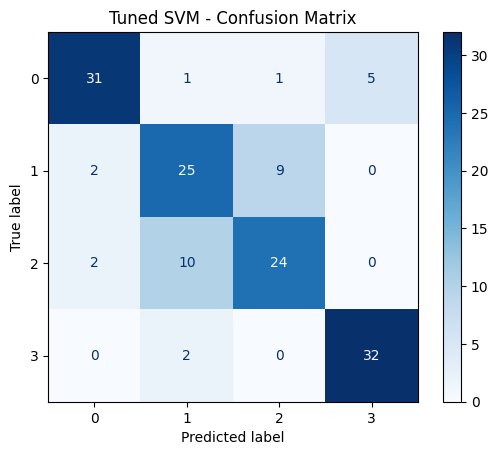


** Tuned XGBoost **
Accuracy: 0.7986111111111112
               precision    recall  f1-score   support

No_Alteration       0.91      0.76      0.83        38
      Calcite       0.73      0.75      0.74        36
    Kaolinite       0.77      0.75      0.76        36
    IronOxide       0.80      0.94      0.86        34

     accuracy                           0.80       144
    macro avg       0.80      0.80      0.80       144
 weighted avg       0.80      0.80      0.80       144



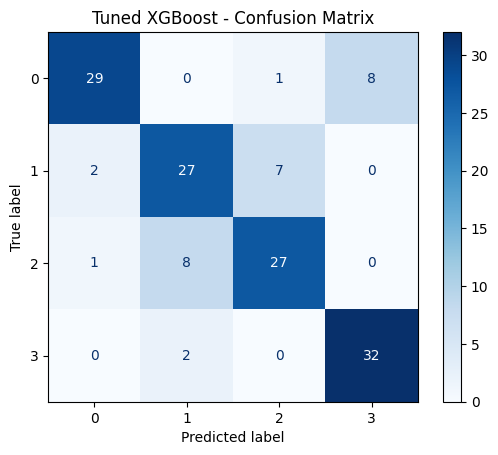

In [20]:
rf_preds_tuned = best_rf.predict(X_test)
svm_preds_tuned = best_svm.predict(X_test)
xgb_preds_tuned = best_xgb.predict(X_test)

tuned_models = {
    "Tuned Random Forest": rf_preds_tuned,
    "Tuned SVM": svm_preds_tuned,
    "Tuned XGBoost": xgb_preds_tuned
}

for name, preds in tuned_models.items():
    print(f"\n** {name} **")
    print("Accuracy:", (preds == y_test).mean())

    print(classification_report(y_test, preds, target_names=Names))

    cm = confusion_matrix(y_test, preds, labels=Classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Classes)
    disp.plot(cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

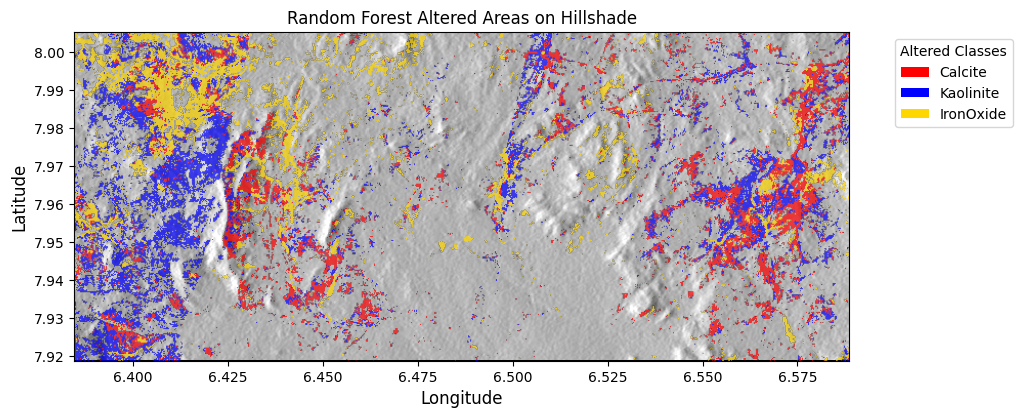

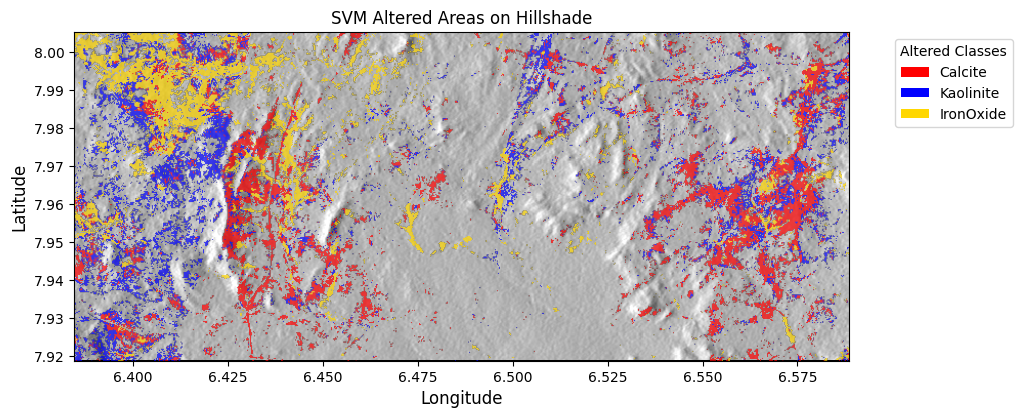

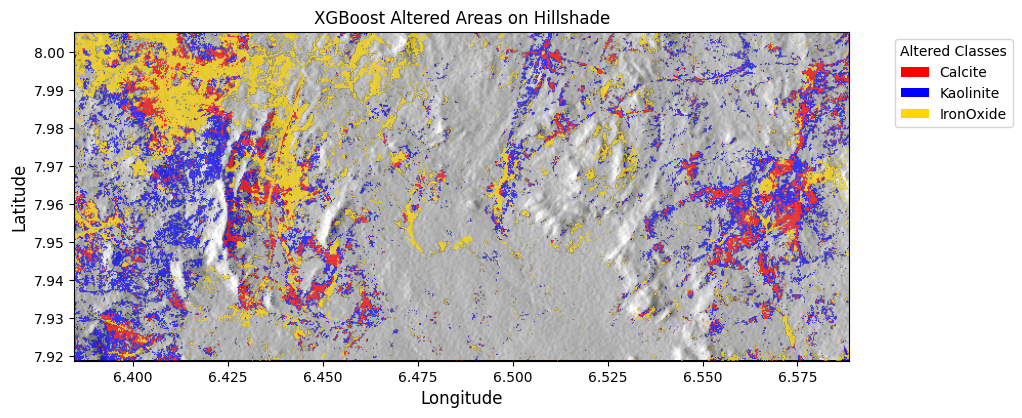

In [21]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import from_levels_and_colors

Hillshade_Path = '/content/drive/MyDrive/GEE_Exports/Hillshade.tif'

try:
    with rasterio.open(Hillshade_Path) as hillshade_image:
        hillshade_array = hillshade_image.read(1) # Read the first band (assuming it's a single-band hillshade)
        hillshade_extent = [hillshade_image.bounds.left, hillshade_image.bounds.right,
                          hillshade_image.bounds.bottom, hillshade_image.bounds.top]
except rasterio.errors.RasterioIOError:
    print(f"Error: Could not open or read the hillshade image at {Hillshade_Path}")
    hillshade_array = None

if 'extent' not in locals():

    bbox = rasterio.coords.BoundingBox(
        left=transform.c,
        bottom=transform.f + transform.e * height,
        right=transform.c + transform.a * width,
        top=transform.f
    )
    extent = [bbox.left, bbox.right, bbox.bottom, bbox.top]

try:
    rf_prediction_map = rf_prediction.reshape(height, width).astype(np.uint8)
    svm_prediction_map = svm_prediction.reshape(height, width).astype(np.uint8)
    xgb_prediction_map = xgb_prediction.reshape(height, width).astype(np.uint8)
except NameError:
    print("Error: Prediction maps (rf_prediction, svm_prediction, xgb_prediction) are not defined.")
    print("Please ensure the previous cells generating these predictions have been run.")
    rf_prediction_map = None
    svm_prediction_map = None
    xgb_prediction_map = None


if hillshade_array is not None and rf_prediction_map is not None:
    remaining_classes = [c for c in Classes if c != 0]
    remaining_names = [Names[i] for i in remaining_classes]
    remaining_palette = [Palette[i] for i in remaining_classes]

    levels_remaining = remaining_classes + [max(remaining_classes) + 1]
    cmap_remaining, norm_remaining = from_levels_and_colors(levels_remaining, remaining_palette)

    mask_rf_no_alteration = (rf_prediction_map == 0)
    mask_svm_no_alteration = (svm_prediction_map == 0)
    mask_xgb_no_alteration = (xgb_prediction_map == 0)

    rf_altered_map = rf_prediction_map.astype(float)
    rf_altered_map[mask_rf_no_alteration] = np.nan

    svm_altered_map = svm_prediction_map.astype(float)
    svm_altered_map[mask_svm_no_alteration] = np.nan

    xgb_altered_map = xgb_prediction_map.astype(float)
    xgb_altered_map[mask_xgb_no_alteration] = np.nan

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(hillshade_array, cmap='gray', extent=hillshade_extent, origin='upper')
    im = ax.imshow(rf_altered_map, cmap=cmap_remaining, norm=norm_remaining, extent=extent, origin='upper', alpha=0.7)
    ax.set_title("Random Forest Altered Areas on Hillshade", fontsize=12)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)

    legend_elements = [plt.matplotlib.patches.Patch(facecolor=remaining_palette[i],
                                                    label=remaining_names[i]) for i in range(len(remaining_classes))]
    ax.legend(handles=legend_elements, title="Altered Classes", loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(hillshade_array, cmap='gray', extent=hillshade_extent, origin='upper') # Plot hillshade first
    im = ax.imshow(svm_altered_map, cmap=cmap_remaining, norm=norm_remaining, extent=extent, origin='upper', alpha=0.7) # Overlay altered map with transparency
    ax.set_title("SVM Altered Areas on Hillshade", fontsize=12)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)

    legend_elements = [plt.matplotlib.patches.Patch(facecolor=remaining_palette[i],
                                                    label=remaining_names[i]) for i in range(len(remaining_classes))]
    ax.legend(handles=legend_elements, title="Altered Classes", loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(hillshade_array, cmap='gray', extent=hillshade_extent, origin='upper') # Plot hillshade first
    im = ax.imshow(xgb_altered_map, cmap=cmap_remaining, norm=norm_remaining, extent=extent, origin='upper', alpha=0.7) # Overlay altered map with transparency
    ax.set_title("XGBoost Altered Areas on Hillshade", fontsize=12)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)

    legend_elements = [plt.matplotlib.patches.Patch(facecolor=remaining_palette[i],
                                                    label=remaining_names[i]) for i in range(len(remaining_classes))]
    ax.legend(handles=legend_elements, title="Altered Classes", loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.show()

else:
    print("Cannot generate plots. Please check for errors in loading the hillshade or prediction maps.")

In [22]:
import os

output_folder = '/content/drive/MyDrive/AGU'
os.makedirs(output_folder, exist_ok=True)

plt.savefig(f"{output_folder}/RF_Altered_Areas.png", dpi=1000, bbox_inches='tight')
plt.savefig(f"{output_folder}/SVM_Altered_Areas.png", dpi=1000, bbox_inches='tight')
plt.savefig(f"{output_folder}/XGBoost_Altered_Areas.png", dpi=1000, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

In [23]:
import os
import matplotlib.pyplot as plt

output_folder = '/content/drive/MyDrive/AGU'
os.makedirs(output_folder, exist_ok=True)

# Create figure with vertical layout
fig, axes = plt.subplots(3, 1, figsize=(12, 30), constrained_layout=True)

# RF Plot
axes[0].imshow(hillshade_array, cmap='gray', extent=hillshade_extent, origin='upper')
axes[0].imshow(rf_altered_map, cmap=cmap_remaining, norm=norm_remaining, extent=extent, origin='upper', alpha=0.7)
axes[0].set_title("Random Forest", fontsize=16)
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")

# SVM Plot
axes[1].imshow(hillshade_array, cmap='gray', extent=hillshade_extent, origin='upper')
axes[1].imshow(svm_altered_map, cmap=cmap_remaining, norm=norm_remaining, extent=extent, origin='upper', alpha=0.7)
axes[1].set_title("SVM", fontsize=16)
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")

# XGBoost Plot
axes[2].imshow(hillshade_array, cmap='gray', extent=hillshade_extent, origin='upper')
axes[2].imshow(xgb_altered_map, cmap=cmap_remaining, norm=norm_remaining, extent=extent, origin='upper', alpha=0.7)
axes[2].set_title("XGBoost", fontsize=16)
axes[2].set_xlabel("Longitude")
axes[2].set_ylabel("Latitude")

# Create a single legend below the last plot
legend_elements = [plt.matplotlib.patches.Patch(facecolor=remaining_palette[i],
                                                label=remaining_names[i]) for i in range(len(remaining_classes))]
fig.legend(handles=legend_elements, title="Altered Classes", loc='lower center',
           bbox_to_anchor=(0.5, -0.02), ncol=len(remaining_classes), fontsize=10, title_fontsize=12)

plt.subplots_adjust(hspace=0.05)  # Tight spacing between maps
plt.savefig(f"{output_folder}/RF_SVM_XGB_Combined_Vertical_Legend.png", dpi=1000, bbox_inches='tight')
plt.close(fig)


/tmp/ipython-input-3937720889.py:37: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.05)  # Tight spacing between maps



** Ensemble Model (Voting) **
Accuracy: 0.8125
               precision    recall  f1-score   support

No_Alteration       0.91      0.84      0.88        38
      Calcite       0.70      0.78      0.74        36
    Kaolinite       0.78      0.69      0.74        36
    IronOxide       0.86      0.94      0.90        34

     accuracy                           0.81       144
    macro avg       0.82      0.81      0.81       144
 weighted avg       0.82      0.81      0.81       144



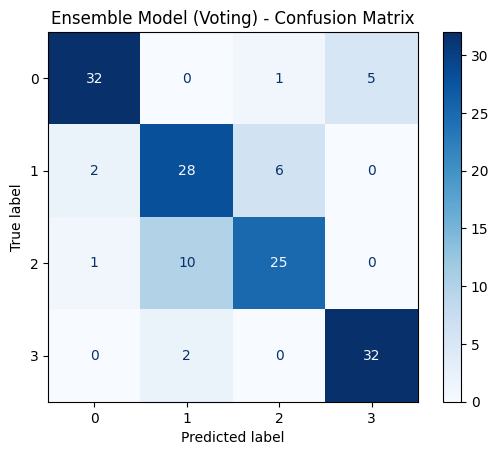

In [24]:
from sklearn.ensemble import VotingClassifier
ensemble_model = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('svm', best_svm),
        ('xgb', best_xgb)
    ],
    voting='hard'
)

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Make predictions with the ensemble model
ensemble_preds = ensemble_model.predict(X_test)

# Evaluate the ensemble model
print("\n** Ensemble Model (Voting) **")
print("Accuracy:", (ensemble_preds == y_test).mean())

# Classification Report
print(classification_report(y_test, ensemble_preds, target_names=Names))

# Confusion Matrix
cm = confusion_matrix(y_test, ensemble_preds, labels=Classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Classes)
disp.plot(cmap='Blues')
plt.title("Ensemble Model (Voting) - Confusion Matrix")
plt.show()

/tmp/ipython-input-1851175682.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=rf_importance_df, palette='viridis')


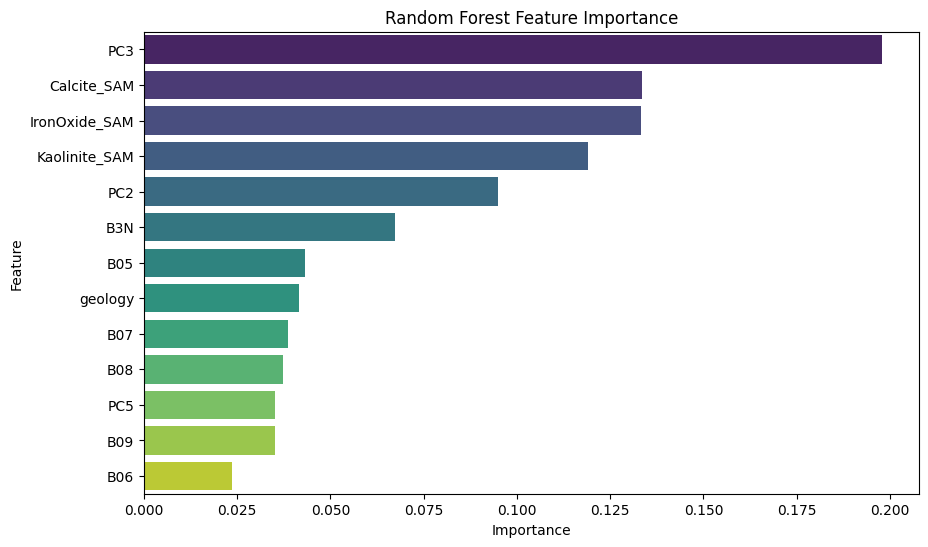

/tmp/ipython-input-1851175682.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=xgb_importance_df, palette='viridis')


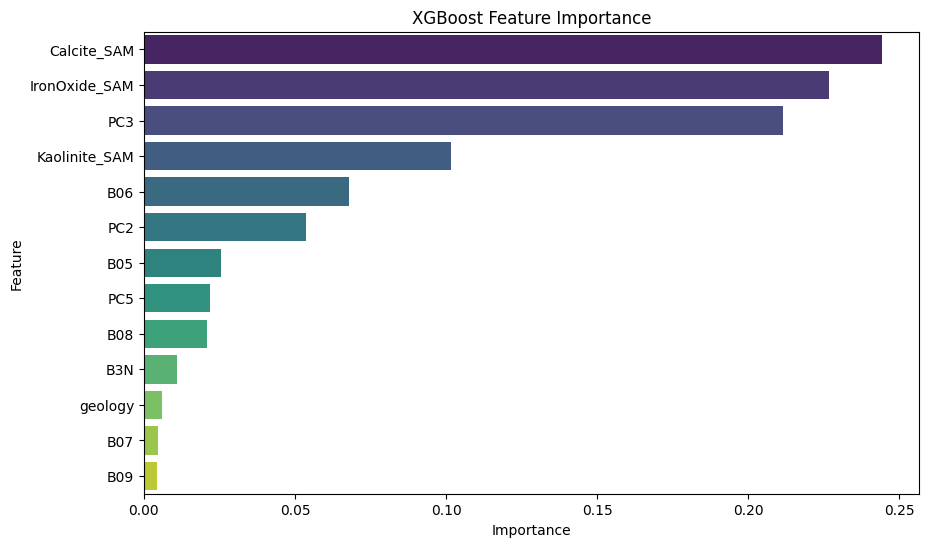

In [26]:
# Get feature importances from Random Forest
rf_feature_importances = best_rf.feature_importances_

# Create a DataFrame for visualization
rf_importance_df = pd.DataFrame({
    'Feature': Bands,
    'Importance': rf_feature_importances
})

# Sort by importance
rf_importance_df = rf_importance_df.sort_values('Importance', ascending=False)

# Plot Random Forest Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rf_importance_df, palette='viridis')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Get feature importances from XGBoost
xgb_feature_importances = best_xgb.feature_importances_

# Create a DataFrame for visualization
xgb_importance_df = pd.DataFrame({
    'Feature': Bands,
    'Importance': xgb_feature_importances
})

# Sort by importance
xgb_importance_df = xgb_importance_df.sort_values('Importance', ascending=False)

# Plot XGBoost Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_importance_df, palette='viridis')
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

                   CNN MODEL
                   

In [27]:
# Install necessary libraries (if not installed)
!pip install rasterio scikit-learn matplotlib tensorflow
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00


In [28]:
import pandas as pd
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import os


In [29]:
Sample_Path = '/content/drive/MyDrive/GEE_Exports/Training_Samples_Fixed.csv'
Image_Path = '/content/drive/MyDrive/GEE_Exports/ImageG_Stacked_Float.tif'

# Define target and predictor variables
Bands = ['PC2', 'PC3', 'PC5', 'geology','B09', 'B08', 'B07', 'B05', 'B06', 'B3N',
  'Calcite_SAM', 'Kaolinite_SAM', 'IronOxide_SAM']
Classes = [0, 1, 2, 3]
N_Classes = 4
Names = ["No_Alteration", "Calcite", "Kaolinite", "IronOxide"]
Palette = [
    '#008000',  # Green  for class 0 (No_Alteration)
    '#FF0000',  # Red    for class 1 (Calcite)
    '#0000FF',  # Blue   for class 2 (Kaolinite)
    '#FFD700',  # Gold   for class 3 (IronOxide)
]
Target = 'class'

# Encode target classes
le = LabelEncoder()
df['label'] = le.fit_transform(df[Target])

# Determine the number of unique classes
num_unique_classes = df['label'].nunique()

# Normalize input
scaler = MinMaxScaler()
X = scaler.fit_transform(df[Bands])
# Fix: Change num_classes to the actual number of unique classes
y = tf.keras.utils.to_categorical(df['label'], num_classes=num_unique_classes)

# Reshape for CNN
X = X.reshape(-1, 1, 1, len(Bands))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers

# Define the model building function for KerasTuner
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(filters=hp.Int('filters', 32, 128, step=32),
                            kernel_size=(1, 1),
                            activation='relu',
                            input_shape=(1, 1, len(Bands))))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=hp.Int('filters_2', 64, 256, step=64), # Add a second Conv2D layer
                            kernel_size=(1, 1),
                            activation='relu',
                            kernel_regularizer=regularizers.l2(hp.Float('l2_reg', 0.0001, 0.01, sampling='log')))) # Tune L2 regularization
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dense(units=hp.Int('units', 32, 128, step=32), activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout', 0.2, 0.5, step=0.1)))
    model.add(layers.Dense(num_unique_classes, activation='softmax'))  # Use the determined number of unique classes

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('lr', [1e-3, 1e-4, 1e-5])), # Tune learning rate
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialize tuner
tuner = kt.RandomSearch(build_model,
                        objective='val_accuracy',
                        max_trials=10,  # Reduced trials for faster execution
                        executions_per_trial=1,
                        directory='alteration_tuning_cnn',
                        project_name='cnn_hyperparam_search')

# Run search
print("Starting hyperparameter search...")
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, verbose=1) # Increased epochs for better tuning

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

print("\nEvaluating the best model on the test data...")
loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

y_pred = best_model.predict(X_test)

Trial 10 Complete [00h 00m 09s]
val_accuracy: 0.6103895902633667

Best val_accuracy So Far: 0.8441558480262756
Total elapsed time: 00h 01m 51s


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Evaluating the best model on the test data...
Test Loss: 1.1165
Test Accuracy: 0.7292
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [31]:
!pip install keras-tuner

In [32]:
def create_model():
    model = models.Sequential([
        layers.Conv2D(64, (1, 1), activation='relu', input_shape=(1, 1, len(Bands))),
        layers.BatchNormalization(),
        layers.Conv2D(128, (1, 1), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_unique_classes, activation='softmax')  # Use the determined number of unique classes
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()

# Train
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    verbose=1
)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3680 - loss: 1.5895 - val_accuracy: 0.4286 - val_loss: 1.4283
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7538 - loss: 0.7489 - val_accuracy: 0.4545 - val_loss: 1.3986
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7630 - loss: 0.6283 - val_accuracy: 0.4805 - val_loss: 1.3786
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7944 - loss: 0.5651 - val_accuracy: 0.4805 - val_loss: 1.3594
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7598 - loss: 0.6567 - val_accuracy: 0.4805 - val_loss: 1.3505
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8426 - loss: 0.5015 - val_accuracy: 0.4805 - val_loss: 1.3408
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7800 - loss: 0.5775 - val_accuracy: 0.4416 - val_loss: 1.3323
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8416 - loss: 0.4598 - val_accuracy: 0.4805 - val_loss

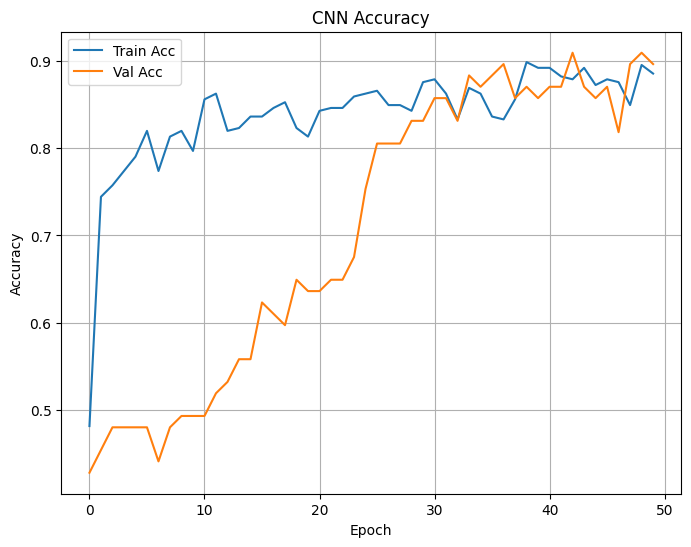

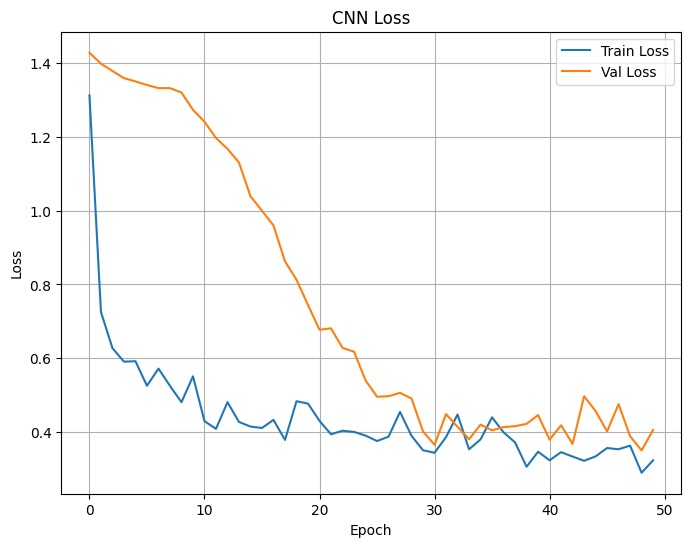

In [33]:
save_path = '/content/drive/MyDrive/PCalcite'

# Accuracy plot
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(f'{save_path}/cnn_accuracy.png', dpi=1000)
plt.show()

# Loss plot
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(f'{save_path}/cnn_loss.png', dpi=1000)
plt.show()


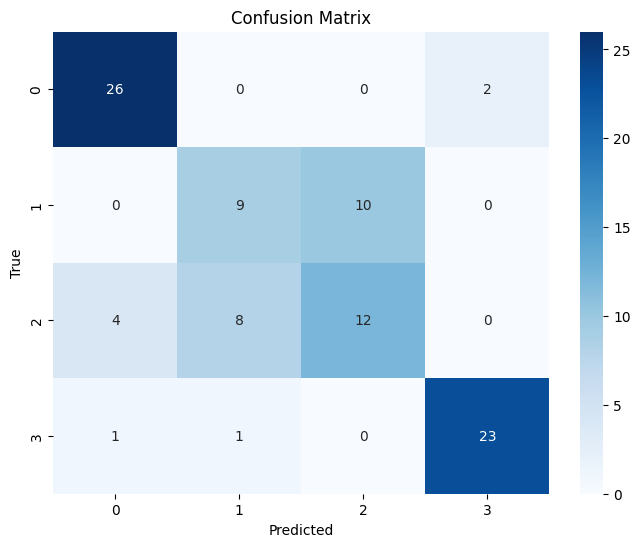

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_labels = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [42]:
# Load the stacked raster
with rasterio.open(Image_Path) as src:
    img = src.read().astype('float32')
    profile = src.profile

# Normalize the image using same scaler
img_reshaped = img.reshape(img.shape[0], -1).T
img_scaled = scaler.transform(img_reshaped)
img_scaled = img_scaled.reshape(-1, 1, 1, len(Bands))

# Predict class for each pixel
predictions = model.predict(img_scaled)
predicted_classes = np.argmax(predictions, axis=1)
pred_map = predicted_classes.reshape(profile['height'], profile['width'])

# Export classified image
out_path = f"{save_path}/Predicted_Map_CNN.tif"
profile.update(dtype=rasterio.uint8, count=1)
with rasterio.open(out_path, 'w', **profile) as dst:
    dst.write(pred_map.astype(rasterio.uint8), 1)

   1/7594 ━━━━━━━━━━━━━━━━━━━━ 6:49 54ms/step

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


7594/7594 ━━━━━━━━━━━━━━━━━━━━ 7s 976us/step


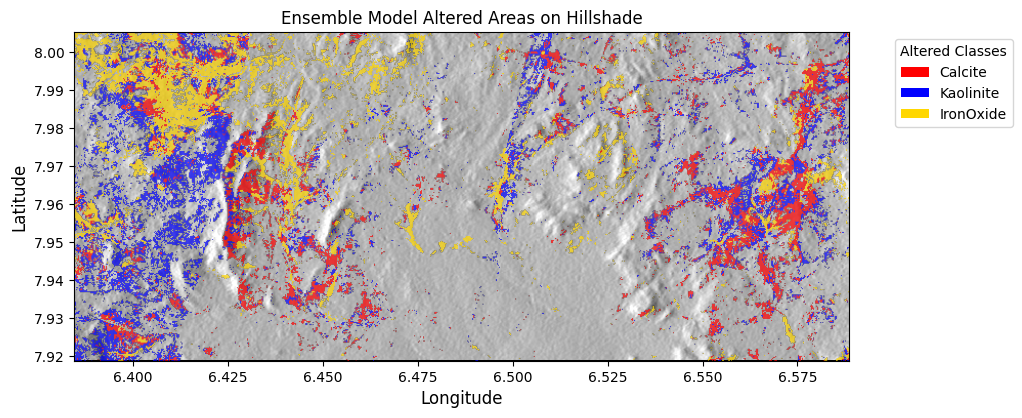

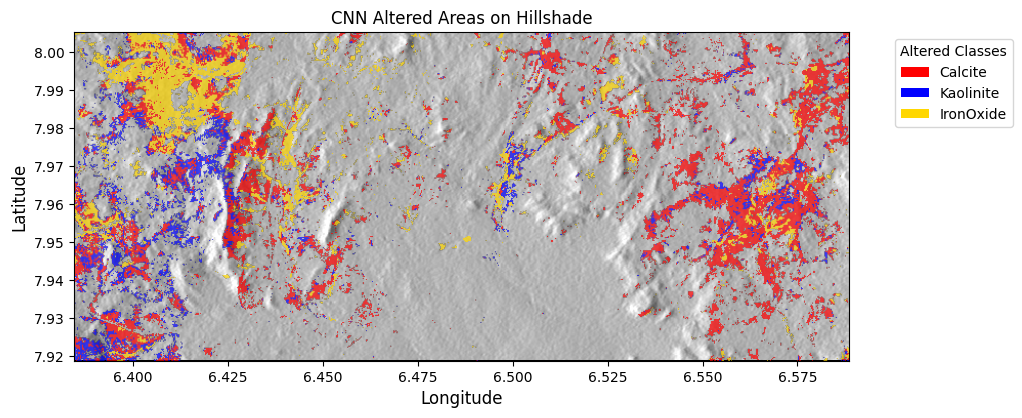

In [41]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import from_levels_and_colors
from matplotlib.patches import Patch

Hillshade_Path = '/content/drive/MyDrive/GEE_Exports/Hillshade.tif'

try:
    with rasterio.open(Hillshade_Path) as hillshade_image:
        hillshade_array = hillshade_image.read(1) # Read the first band (assuming it's a single-band hillshade)
        hillshade_extent = [hillshade_image.bounds.left, hillshade_image.bounds.right,
                          hillshade_image.bounds.bottom, hillshade_image.bounds.top]
except rasterio.errors.RasterioIOError:
    print(f"Error: Could not open or read the hillshade image at {Hillshade_Path}")
    hillshade_array = None

if 'extent' not in locals():
    try:
        bbox = rasterio.coords.BoundingBox(
            left=transform.c,
            bottom=transform.f + transform.e * height,
            right=transform.c + transform.a * width,
            top=transform.f
        )
        extent = [bbox.left, bbox.right, bbox.bottom, bbox.top]
    except NameError:
        print("Error: 'transform', 'height', or 'width' not defined. Cannot calculate extent.")
        extent = None

try:
    if 'ensemble_prediction' not in locals():
        print("Error: 'ensemble_prediction' is not defined. Please run the cell that generates ensemble predictions.")
        ensemble_prediction_map = None
    else:
        ensemble_prediction_map = ensemble_prediction.reshape(height, width).astype(np.uint8)

    if 'predicted_classes' not in locals():
        print("Error: 'predicted_classes' (CNN) is not defined. Please run the cell that generates CNN predictions.")
        cnn_prediction_map = None
    else:
        cnn_prediction_map = predicted_classes.reshape(height, width).astype(np.uint8)

except NameError:
    print("Error: 'height' or 'width' not defined. Cannot reshape prediction maps.")
    ensemble_prediction_map = None
    cnn_prediction_map = None


if hillshade_array is not None and extent is not None:
    remaining_classes = [c for c in Classes if c != 0]
    remaining_names = [Names[i] for i in remaining_classes]
    remaining_palette = [Palette[i] for i in remaining_classes]

    levels_remaining = remaining_classes + [max(remaining_classes) + 1]
    cmap_remaining, norm_remaining = from_levels_and_colors(levels_remaining, remaining_palette)


    if ensemble_prediction_map is not None:

        mask_ensemble_no_alteration = (ensemble_prediction_map == 0)

        ensemble_altered_map = ensemble_prediction_map.astype(float)
        ensemble_altered_map[mask_ensemble_no_alteration] = np.nan

        fig, ax = plt.subplots(figsize=(10, 8))
        ax.imshow(hillshade_array, cmap='gray', extent=hillshade_extent, origin='upper')
        im = ax.imshow(ensemble_altered_map, cmap=cmap_remaining, norm=norm_remaining, extent=extent, origin='upper', alpha=0.7)
        ax.set_title("Ensemble Model Altered Areas on Hillshade", fontsize=12)
        ax.set_xlabel("Longitude", fontsize=12)
        ax.set_ylabel("Latitude", fontsize=12)


        legend_elements = [Patch(facecolor=remaining_palette[i],
                                                        label=remaining_names[i]) for i in range(len(remaining_classes))]
        ax.legend(handles=legend_elements, title="Altered Classes", loc='upper left', bbox_to_anchor=(1.05, 1))

        plt.show()

    if cnn_prediction_map is not None:

        mask_cnn_no_alteration = (cnn_prediction_map == 0)


        cnn_altered_map = cnn_prediction_map.astype(float)
        cnn_altered_map[mask_cnn_no_alteration] = np.nan

        fig, ax = plt.subplots(figsize=(10, 8))
        ax.imshow(hillshade_array, cmap='gray', extent=hillshade_extent, origin='upper')
        im = ax.imshow(cnn_altered_map, cmap=cmap_remaining, norm=norm_remaining, extent=extent, origin='upper', alpha=0.7)
        ax.set_title("CNN Altered Areas on Hillshade", fontsize=12)
        ax.set_xlabel("Longitude", fontsize=12)
        ax.set_ylabel("Latitude", fontsize=12)


        legend_elements = [Patch(facecolor=remaining_palette[i],
                                                        label=remaining_names[i]) for i in range(len(remaining_classes))]
        ax.legend(handles=legend_elements, title="Altered Classes", loc='upper left', bbox_to_anchor=(1.05, 1))

        plt.show()


elif hillshade_array is None:
    print("Cannot generate plots because the hillshade image could not be loaded.")
else:
     print("Cannot generate plots because prediction maps or extent could not be determined.")